In [5]:
import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt

%matplotlib inline

Sample rate: 16000Hz
Audio duration: 11.14s


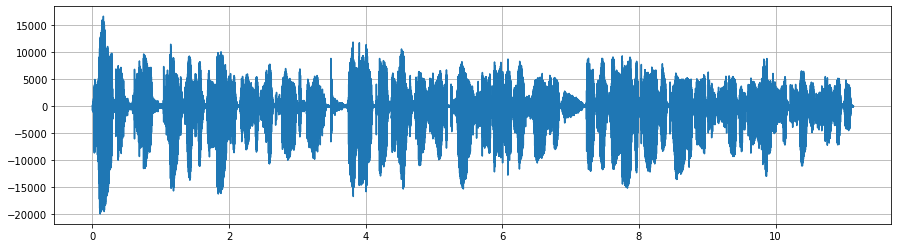

In [6]:
# AUDIO

filename = "../f2bjrop1.0.wav"
sample_rate, audio = wavfile.read(filename)
print("Sample rate: {0}Hz".format(sample_rate))
print("Audio duration: {0}s".format(len(audio) / sample_rate))
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.grid(True)

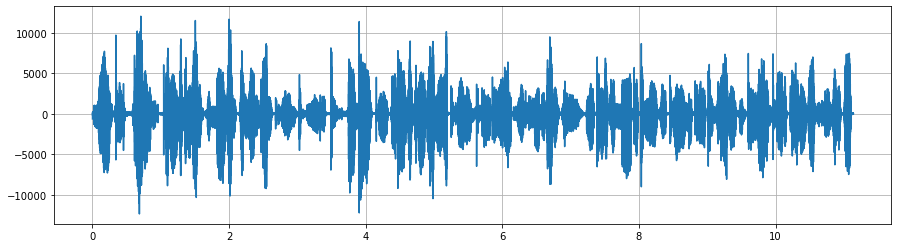

In [7]:
# PRE EMPHASIS

emphasis_coeff = 0.96875
audio_emphasis = np.append(audio[0], audio[1:] - emphasis_coeff * audio[:-1])
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio_emphasis) / sample_rate, num=len(audio_emphasis)), audio_emphasis)
plt.grid(True)

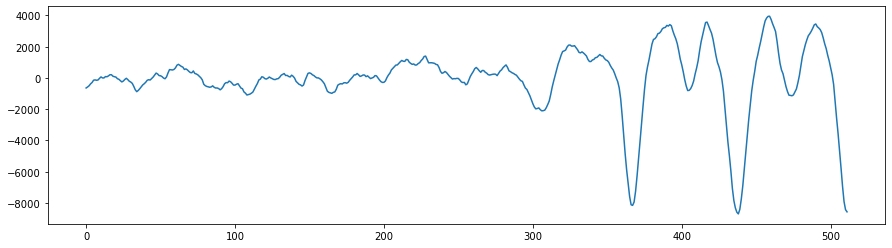

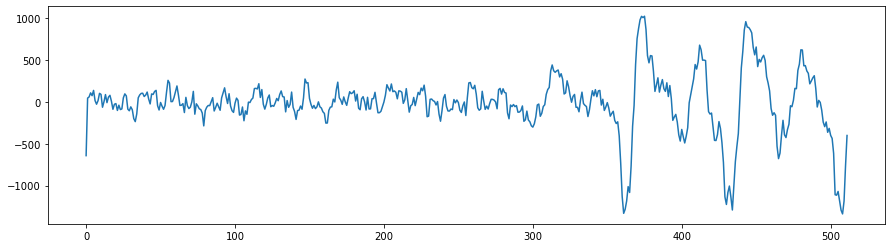

In [8]:
# FRAME

FFT_size = 512
hop_len = FFT_size // 3
findex = 0
off = findex * hop_len
# frame = audio[off-FFT_size//2:off+FFT_size//2]
frame_audio = audio[off:off+FFT_size]
plt.figure(figsize=(15,4))
plt.plot(frame_audio)

frame_emphasis = audio_emphasis[off:off+FFT_size]
plt.figure(figsize=(15,4))
plt.plot(frame_emphasis)

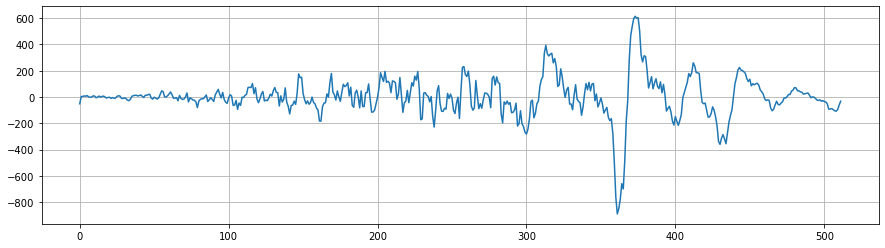

In [9]:
# WINDOW

window = get_window("hamm", FFT_size, fftbins=True)
audio_win = frame_emphasis * window

plt.figure(figsize=(15,4))
plt.plot(audio_win)
plt.grid(True)

/usr/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


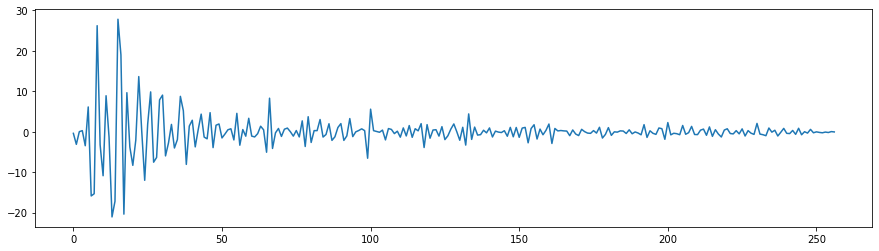

In [10]:
# FFT

size = int(1 + FFT_size // 2)
audio_fft = fft.fft(audio_win, axis=0)[0:size]
audio_fft /= 512

plt.figure(figsize=(15,4))
plt.plot(audio_fft)

# print(audio_fft)

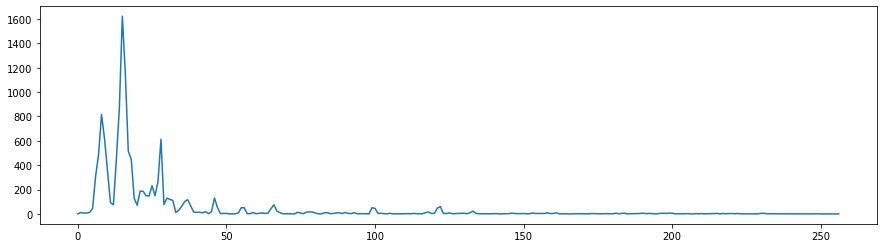

In [11]:
# POWER SPECTRUM

audio_power = np.square(np.abs(audio_fft))
plt.figure(figsize=(15,4))
plt.plot(audio_power)

In [12]:
# FILTER BANK

freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 32

def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int)

def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

[  0   1   3   5   8  10  13  15  18  22  25  29  33  38  42  48  53  59
  66  73  80  89  97 107 117 128 140 153 167 183 199 216 235 256]
[  11   14  210 1455 1022  571 3068 1650  537  640 1041  324  312   85
  181   62   78  160   36   66   52   91   44  101  103   34   46   27
   39   44   32   24]


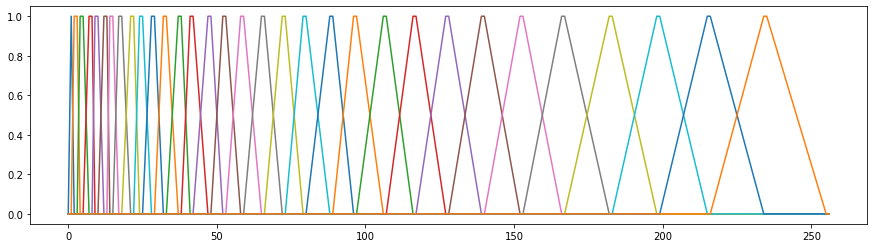

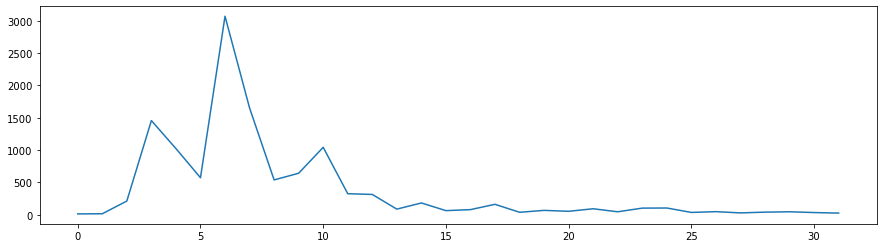

In [13]:
filter_points = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=sample_rate)
print(filter_points)

filters = get_filters(filter_points, FFT_size)
plt.figure(figsize=(15,4))
for n in range(len(filters)):
    plt.plot(filters[n])

audio_filtered = np.dot(filters, audio_power)
print(audio_filtered.astype(int))
# print((audio_filtered / 2 / 65536))
plt.figure(figsize=(15,4))
plt.plot(audio_filtered)

[ 3.55230325  3.82544315  7.72071372 10.50716696  9.9977873   9.15844432
 11.58338948 10.68856335  9.07001692  9.32346505 10.02447032  8.34046857
  8.28878333  6.42217547  7.50133799  5.96442018  6.28892354  7.32281616
  5.20400827  6.05692018  5.70729914  6.51455008  5.48471721  6.66293747
  6.68821423  5.11366739  5.54509401  4.78063014  5.28740864  5.49175557
  5.03558737  4.6116019 ]
[ 3.  3.  7. 10.  9.  9. 11. 10.  9.  9. 10.  8.  8.  6.  7.  5.  6.  7.
  5.  6.  5.  6.  5.  6.  6.  5.  5.  4.  5.  5.  5.  4.]


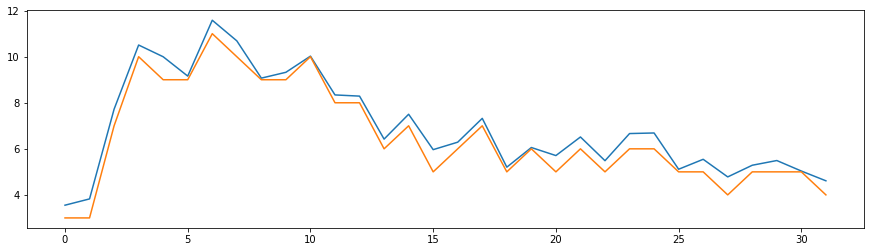

In [14]:
# LOG

# audio_log = [np.log2(audio_filtered / (2**i)) for i in range(1, 18)]
audio_log = np.log2(audio_filtered) #  / 2 / 65536)
print(audio_log)

plt.figure(figsize=(15,4))
# for a in audio_log:
#     plt.plot(a)
plt.plot(audio_log)
#328048

prec = 0
audio_scale = (audio_log * (2**prec)).astype(int) / (2**prec)
print(audio_scale)
plt.plot(audio_scale)

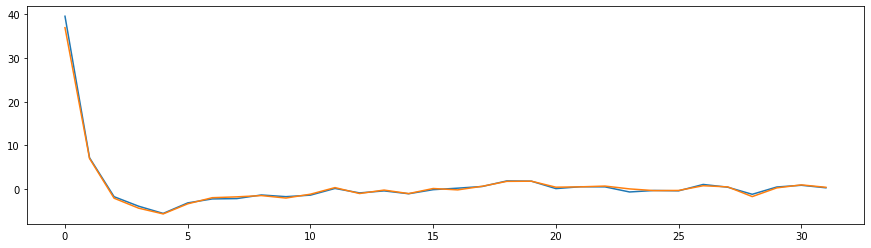

In [15]:
# DCT (implemented with 4 FFT)
# https://dsp.stackexchange.com/questions/2807/fast-cosine-transform-via-fft

dct_filter_num = mel_filter_num

audio_dct = scipy.fft.dct(audio_log, type=2, norm="ortho")
audio_dct_scale = scipy.fft.dct(audio_scale, type=2, norm="ortho")

plt.figure(figsize=(15,4))
# for a in audio_dct:
#     plt.plot(a)
plt.plot(audio_dct)
plt.plot(audio_dct_scale)